In [ ]:
### densenet 
import os
import tensorflow as tf
import keras

from tensorflow.keras import layers, models, backend, utils, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#코랩 마운트
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/face2

/content/drive/MyDrive/face2


In [ ]:
#압축해제
#!unzip -qq "/content/drive/MyDrive/r-vs-f.zip"

In [ ]:
#개수 확인(14만개 중 1/10사용)
from glob import glob
filepaths1 = list(glob('/content/drive/MyDrive/face2/train/real/*.jpg'))
filepaths2 = list(glob('/content/drive/MyDrive/face2/test/real/*.jpg'))
filepaths3 = list(glob('/content/drive/MyDrive/face2/valid/real/*.jpg'))
print(len(filepaths1), len(filepaths2), len(filepaths3))

5000 1000 1000


In [ ]:
#데이터 경로 지정 등 설정
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator()

path = '/content/drive/My Drive/face2/'

train_generator = image_gen.flow_from_directory(
    path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    color_mode='rgb',
    class_mode='binary'
)

valid_generator = image_gen.flow_from_directory(
    path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    color_mode='rgb',
    class_mode='binary'
)

test_generator = image_gen.flow_from_directory(
    path + 'test/',
    target_size=(224, 224),
    batch_size=64,
    color_mode='rgb',
    shuffle = False,
    class_mode='binary'
)

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
#densenet import 및 모델링
from tensorflow.keras.applications import DenseNet121

densenet = DenseNet121( weights='imagenet', include_top=False, input_shape=(224,224,3) )

model = models.Sequential()

model = models.Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
#모델 학습
train_steps = 10000//64
valid_steps = 2000//64

hist = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_steps
)

Epoch 1/20
157/157 [==============================] - 60s 235ms/step - loss: 0.3516 - accuracy: 0.8451 - val_loss: 2.0477 - val_accuracy: 0.5912
Epoch 2/20
157/157 [==============================] - 34s 216ms/step - loss: 0.1506 - accuracy: 0.9410 - val_loss: 0.5308 - val_accuracy: 0.7923
Epoch 3/20
157/157 [==============================] - 33s 212ms/step - loss: 0.0928 - accuracy: 0.9642 - val_loss: 0.2606 - val_accuracy: 0.9224
Epoch 4/20
157/157 [==============================] - 33s 212ms/step - loss: 0.0734 - accuracy: 0.9739 - val_loss: 0.6135 - val_accuracy: 0.8140
Epoch 5/20
157/157 [==============================] - 33s 211ms/step - loss: 0.0526 - accuracy: 0.9815 - val_loss: 0.9963 - val_accuracy: 0.6648
Epoch 6/20
157/157 [==============================] - 34s 215ms/step - loss: 0.0459 - accuracy: 0.9824 - val_loss: 0.2038 - val_accuracy: 0.9259
Epoch 7/20
157/157 [==============================] - 34s 216ms/step - loss: 0.0452 - accuracy: 0.9850 - val_loss: 1.7304 - val_ac

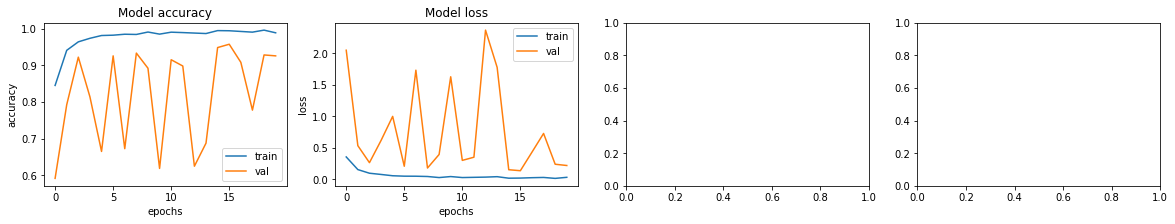

In [ ]:
#acc 및 loss plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [ ]:
#test 평가
model.evaluate(test_generator)

32/32 [==============================] - 6s 170ms/step - loss: 0.1979 - accuracy: 0.9345


[0.19785426557064056, 0.934499979019165]

In [ ]:
#이미지 대입
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image

test_image = image.load_img('/content/drive/MyDrive/11/fake2.jpg', target_size=(224, 224, 3))
plt.imshow(test_image)

fix_img = image.img_to_array(test_image)
fix_img = np.expand_dims(test_image, axis=0)

In [ ]:
#사진이 real인지 fake인지 출력
preds = model.predict(fix_img)
pct = np.max(preds)
if preds < 0.5:
    print('The Prediction of the sample is: It Is fake')
else:
    print('Prediction is real')
plt.imshow(test_image)

In [ ]:
#혼동행렬
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(np.int)

plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(test_generator.classes, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [ ]:
#AUC
print("ROC-AUC Score:", metrics.roc_auc_score(test_generator.classes, y_pred))
print("AP Score:", metrics.average_precision_score(test_generator.classes, y_pred))

print(metrics.classification_report(test_generator.classes, y_pred > 0.5))